In [1]:
import ee
import geemap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# Initialize the library.
ee.Initialize()

## Configuration

In [3]:
LABEL_DICT = {'built': 6, 'water': 0, 'tree': 1, 'grass': 2, 'flooded_veg': 3, 'crop': 4, 
             'shrub': 5, 'bare': 7}#, 'snow': 8}
COLOR_DICT = {'built': '#C4281B', 'water': '#419BDF', 'tree': '#397D49', 'grass': '#88B053', 
              'flooded_veg': '#7A87C6', 'crop': '#E49635', 
             'shrub': '#DFC35A', 'bare': '#A59B8F'}#, 'snow': '#B39FE1'}

In [4]:
csv_file = 'DBR_Excel_data_pro.csv'

## Load bridge info

In [5]:
df = pd.read_csv(csv_file)

In [6]:
df.head()

,Unnamed: 0,S.No,Bridge_No,Bridge_Name,Bridge_Type,Bridge_Span,River_Name,Trail_Type,District,Major_VDC,...,State,Ward_No,Latitude,Longitude,Const_Year,Local_Fund,Foreign_Agency,Bridge Condition,start_year,end_year
0,0,1,01 5 002 18 06 01,Jogi Rumba,D,50,Sobuwa khola,Local,Taplejung,Hangdewa,...,1,NaN,27.377915,87.697766,2005/06,VDC,SDC,No action required,2005,2006
1,1,2,01 5 002 18 06 02,Dhupaure,ST,32,Dhupaure Khola,Local,Taplejung,Hangdewa,...,1,NaN,27.364250,87.708946,1999/2000,Other,KAABGN,No action required,1999,2000
2,2,3,01 5 003 18 06 04,Mauwa Khola,D,60.5,Mauwa Khola,Main,Taplejung,Phuurumbu,...,1,NaN,27.413410,87.720686,2004/05,Other,KAABGN,No action required,2004,2005
3,3,4,01 5 003 18 06 05,Gopani,D,50,Gopani Khola,Local,Taplejung,Phuurumbu,...,1,NaN,27.398313,87.731395,2007/08,VDC,DRILP+SDC/DFID,No action required,2007,2008
4,4,5,01 5 004 18 06 01,Thouwa,D,37,Sisne Khola,Local,Taplejung,Limkhim,...,1,NaN,27.428107,87.713575,1998/99,VDC,SDC,No action required,1998,1999


take one bridge as example

In [7]:
df.loc[6000]

Unnamed: 0                        7804
S.No                              7805
Bridge_No           04 3 0803 18 06 11
Bridge_Name             Simtada (LSTB)
Bridge_Type                         LD
Bridge_Span                        165
River_Name                 Thuli Bheri
Trail_Type                       Local
District                 Western Rukum
Major_VDC             Aathbiskot Na Pa
Major Palika          Aathbiskot Na Pa
State                                0
Ward_No                            NaN
Latitude                     28.825828
Longitude                    82.381146
Const_Year                   2019/2020
Local_Fund                         NaN
Foreign_Agency                    SWAp
Bridge Condition    No action required
start_year                        2019
end_year                          2020
Name: 6000, dtype: object

In [8]:
bridge = df.loc[6000]

## Compute annual-averaged fraction of built-area around this bridge

In [9]:
def getAnnualFraction(lon, lat, year, label='built', distance=1000):
    # creat point
    point = ee.Geometry.Point(lon, lat)
    
    # creat buffer as geometry
    geometry = point.buffer(distance=distance)
    
    # define time range (annual)
    startDate = '{}-01-01'.format(year)
    endDate = '{}-01-01'.format(int(year)+1)
    
    if label not in list(LABEL_DICT.keys()):
        print('UNKNOWN CLASS NAME')
        return
    label_idx = LABEL_DICT[label]
    print('generate {} fraction for year {} at ({}, {})'.format(label, year, lon, lat))
    
    # get annual composite Dynamic World Product
    dw = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1').filterDate(startDate, endDate).filterBounds(geometry)
    classification = dw.select('label')
    dwComposite = classification.reduce(ee.Reducer.mode())
    
    # compute fraction
    area = dwComposite.eq(label_idx)
    dwComposite = dwComposite.rename(['classification'])
    area = area.rename([label])
    
    # Count all pixels.
    statsTotal = area.reduceRegion(
        reducer=ee.Reducer.count(),
        geometry=geometry,
        scale=10,
        maxPixels=1e10
        )
    totalPixels = statsTotal.get(label).getInfo()

    # Mask 0 pixel values and count remaining pixels.
    areaMasked = area.selfMask()

    statsMasked = areaMasked.reduceRegion(
        reducer=ee.Reducer.count(),
        geometry=geometry,
        scale=10,
        maxPixels=1e10
        )
    areaPixels = statsMasked.get(label).getInfo()
    
    fraction = areaPixels/totalPixels

    print('{}/total = {}/{} = {} %'.format(label, areaPixels, totalPixels, 
                                             fraction, 100*fraction))
    return totalPixels, areaPixels, fraction

In [10]:
lat, lon = bridge['Latitude'], bridge['Longitude']
start_year, end_year = bridge['start_year'], bridge['end_year']

In [11]:
results = {}
for l in LABEL_DICT:
    results[l] = {}
    results[l]['fractions'], results[l]['years'] = [], []
    for y in range(start_year-3, end_year+3):
        _, _, fraction = getAnnualFraction(lon, lat, y, label=l, distance=1000)
        results[l]['fractions'].append(fraction)
        results[l]['years'].append(y)

generate built fraction for year 2016 at (82.38114581, 28.8258284)
built/total = 63/35511 = 0.0017740981667652277 %
generate built fraction for year 2017 at (82.38114581, 28.8258284)
built/total = 70/35511 = 0.001971220185294697 %
generate built fraction for year 2018 at (82.38114581, 28.8258284)
built/total = 98/35511 = 0.0027597082594125765 %
generate built fraction for year 2019 at (82.38114581, 28.8258284)
built/total = 71/35511 = 0.0019993804736560504 %
generate built fraction for year 2020 at (82.38114581, 28.8258284)
built/total = 90/35511 = 0.0025344259525217536 %
generate built fraction for year 2021 at (82.38114581, 28.8258284)
built/total = 219/35511 = 0.006167103151136268 %
generate built fraction for year 2022 at (82.38114581, 28.8258284)
built/total = 212/35511 = 0.005969981132606798 %
generate water fraction for year 2016 at (82.38114581, 28.8258284)
water/total = 1641/35511 = 0.04621103320097998 %
generate water fraction for year 2017 at (82.38114581, 28.8258284)
water/

## Visualization

In [12]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Land Cover Fraction for Bridge at (82.38114581, 28.8258284) from 2016 - 2022')

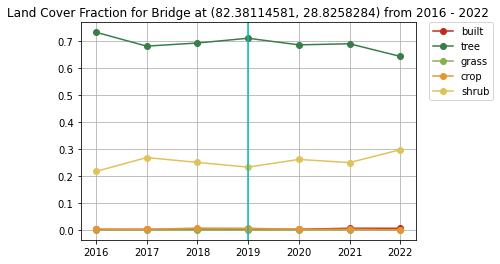

In [13]:
label_vis = ['built', 'tree', 'grass', 'crop', 'shrub']

for l in label_vis:
    plt.plot(results[l]['years'], results[l]['fractions'], '-o', label=l, color=COLOR_DICT[l])

# plot const year of bridge
plt.axvline(x=results[l]['years'][len(results[l]['years'])//2], color='c')
plt.grid()

plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
plt.title('Land Cover Fraction for Bridge at ({}, {}) from {} - {}'.format(lon, lat, start_year-3, end_year+2))

Text(0.5, 1.0, 'Land Cover Fraction for Bridge at (82.38114581, 28.8258284) from 2016 - 2022')

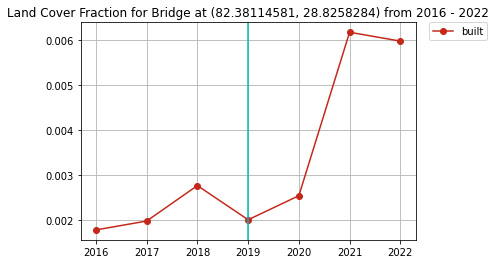

In [14]:
label_vis = ['built']

for l in label_vis:
    plt.plot(results[l]['years'], results[l]['fractions'], '-o', label=l, color=COLOR_DICT[l])

# plot const year of bridge
plt.axvline(x=results[l]['years'][len(results[l]['years'])//2], color='c')
plt.grid()

plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
plt.title('Land Cover Fraction for Bridge at ({}, {}) from {} - {}'.format(lon, lat, start_year-3, end_year+2))

## Visualze the +/- percentage

Text(0.5, 1.0, 'Land Cover Fraction (relative) for Bridge at (82.38114581, 28.8258284) from 2016 - 2022')

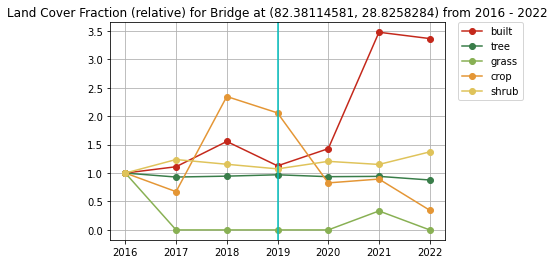

In [15]:
label_vis = ['built', 'tree', 'grass', 'crop', 'shrub']

for l in label_vis:
    percent = np.array(results[l]['fractions'])/results[l]['fractions'][0]
    plt.plot(results[l]['years'], percent, '-o', label=l, color=COLOR_DICT[l])

# plot const year of bridge
plt.axvline(x=results[l]['years'][len(results[l]['years'])//2], color='c')
plt.grid()

plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
plt.title('Land Cover Fraction (relative) for Bridge at ({}, {}) from {} - {}'.format(lon, lat, start_year-3, end_year+2))